In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn import model_selection
import os

In [2]:
RANDOM_SEED = 42
NUM_CLASSES = 25
dataset = 'keypoint_classifier/keypoint_key_letters_both_aug.csv'
model_save_path = 'keypoint_classifier/GRU_model_both_aug.hdf5'

In [3]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [4]:

X_train = X_train[:, None, :]
print(X_train.shape)

(1983, 1, 42)


In [5]:
X_test = X_test[:, None, :]
print(X_test.shape)

(662, 1, 42)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1,42)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [7]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 50)             14100     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
Total params: 62,225
Trainable params: 62,225
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/13 [=>............................] - ETA: 25s - loss: 3.2241 - accuracy: 0.0156
Epoch 1: saving model to keypoint_classifier\GRU_model_both_aug.hdf5
13/13 [==============================] - 3s 43ms/step - loss: 3.2056 - accuracy: 0.0549 - val_loss: 3.1848 - val_accuracy: 0.0907
Epoch 2/500
 1/13 [=>............................] - ETA: 0s - loss: 3.1822 - accuracy: 0.0625
Epoch 2: saving model to keypoint_classifier\GRU_model_both_aug.hdf5
13/13 [==============================] - 0s 7ms/step - loss: 3.1582 - accuracy: 0.1110 - val_loss: 3.1437 - val_accuracy: 0.0932
Epoch 3/500
 1/13 [=>............................] - ETA: 0s - loss: 3.1277 - accuracy: 0.1250
Epoch 3: saving model to keypoint_classifier\GRU_model_both_aug.hdf5
13/13 [==============================] - 0s 7ms/step - loss: 3.1015 - accuracy: 0.1154 - val_loss: 3.0798 - val_accuracy: 0.0957
Epoch 4/500
 1/13 [=>............................] - ETA: 0s - loss: 3.0477 - accuracy: 0.1484
Epoch 4: saving model to

21/21 [==============================] - 0s 1ms/step


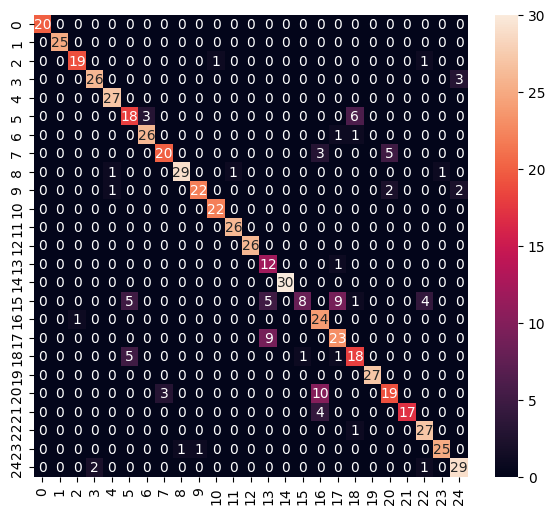

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        25
           2       0.95      0.90      0.93        21
           3       0.93      0.90      0.91        29
           4       0.93      1.00      0.96        27
           5       0.64      0.67      0.65        27
           6       0.90      0.93      0.91        28
           7       0.87      0.71      0.78        28
           8       0.97      0.91      0.94        32
           9       0.96      0.81      0.88        27
          10       0.96      1.00      0.98        22
          11       0.96      1.00      0.98        26
          12       1.00      1.00      1.00        26
          13       0.46      0.92      0.62        13
          14       1.00      1.00      1.00        30
          15       0.89      0.25      0.39        32
          16       0.59      0.96      0.73        25
     

In [9]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [10]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        20
           1      1.000     1.000     1.000        25
           2      0.950     0.905     0.927        21
           3      0.929     0.897     0.912        29
           4      0.931     1.000     0.964        27
           5      0.643     0.667     0.655        27
           6      0.897     0.929     0.912        28
           7      0.870     0.714     0.784        28
           8      0.967     0.906     0.935        32
           9      0.957     0.815     0.880        27
          10      0.957     1.000     0.978        22
          11      0.963     1.000     0.981        26
          12      1.000     1.000     1.000        26
          13      0.462     0.923     0.615        13
          14      1.000     1.000     1.000        30
          15      0.889     0.250     0.390        32
          16      0.585     0.960     0.727        25
          17      0.657    

Text(0.5, 1.0, 'Loss')

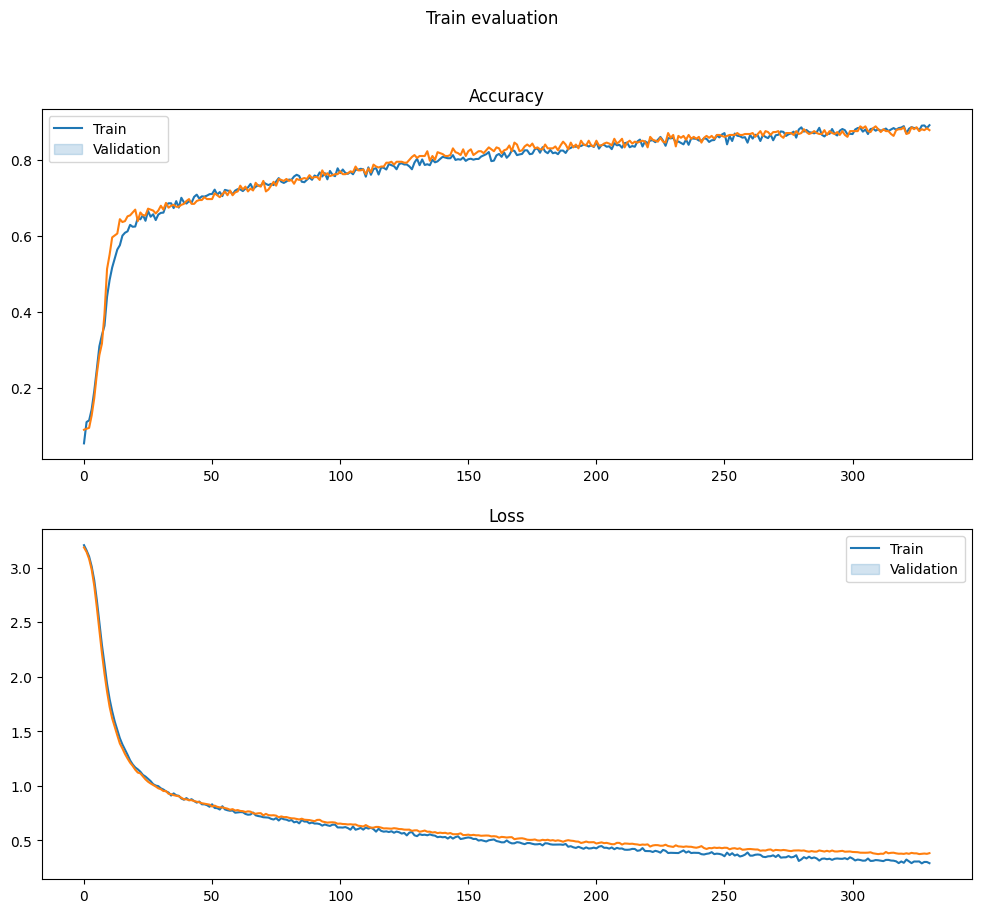

In [11]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [12]:
model_save_path = 'keypoint_classifier/LSTM_model_both_aug.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [13]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             18600     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
Total params: 81,525
Trainable params: 81,525
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/13 [=>............................] - ETA: 23s - loss: 3.2174 - accuracy: 0.0312
Epoch 1: saving model to keypoint_classifier\LSTM_model_both_aug.hdf5
13/13 [==============================] - 3s 45ms/step - loss: 3.2150 - accuracy: 0.0776 - val_loss: 3.2128 - val_accuracy: 0.1033
Epoch 2/500
 1/13 [=>............................] - ETA: 0s - loss: 3.2088 - accuracy: 0.1328
Epoch 2: saving model to keypoint_classifier\LSTM_model_both_aug.hdf5
13/13 [==============================] - 0s 7ms/step - loss: 3.2031 - accuracy: 0.1021 - val_loss: 3.2035 - val_accuracy: 0.0957
Epoch 3/500
 1/13 [=>............................] - ETA: 0s - loss: 3.1986 - accuracy: 0.0781
Epoch 3: saving model to keypoint_classifier\LSTM_model_both_aug.hdf5
13/13 [==============================] - 0s 7ms/step - loss: 3.1844 - accuracy: 0.1122 - val_loss: 3.1852 - val_accuracy: 0.1058
Epoch 4/500
 1/13 [=>............................] - ETA: 0s - loss: 3.1748 - accuracy: 0.1016
Epoch 4: saving model

21/21 [==============================] - 0s 1ms/step


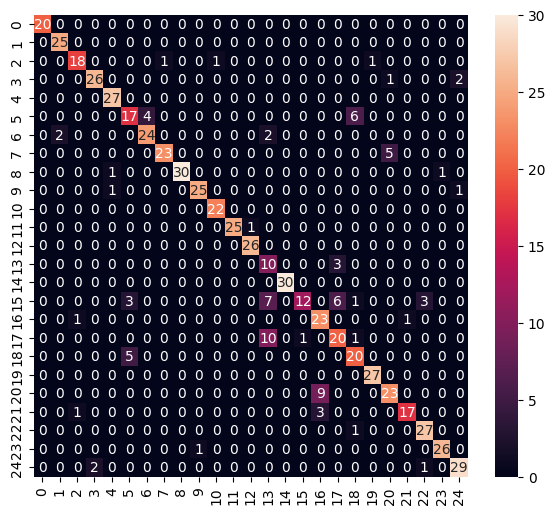

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.93      1.00      0.96        25
           2       0.90      0.86      0.88        21
           3       0.93      0.90      0.91        29
           4       0.93      1.00      0.96        27
           5       0.68      0.63      0.65        27
           6       0.86      0.86      0.86        28
           7       0.96      0.82      0.88        28
           8       1.00      0.94      0.97        32
           9       0.96      0.93      0.94        27
          10       0.96      1.00      0.98        22
          11       1.00      0.96      0.98        26
          12       0.96      1.00      0.98        26
          13       0.34      0.77      0.48        13
          14       1.00      1.00      1.00        30
          15       0.92      0.38      0.53        32
          16       0.66      0.92      0.77        25
     

In [15]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [16]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        20
           1      0.926     1.000     0.962        25
           2      0.900     0.857     0.878        21
           3      0.929     0.897     0.912        29
           4      0.931     1.000     0.964        27
           5      0.680     0.630     0.654        27
           6      0.857     0.857     0.857        28
           7      0.958     0.821     0.885        28
           8      1.000     0.938     0.968        32
           9      0.962     0.926     0.943        27
          10      0.957     1.000     0.978        22
          11      1.000     0.962     0.980        26
          12      0.963     1.000     0.981        26
          13      0.345     0.769     0.476        13
          14      1.000     1.000     1.000        30
          15      0.923     0.375     0.533        32
          16      0.657     0.920     0.767        25
          17      0.690    

Text(0.5, 1.0, 'Loss')

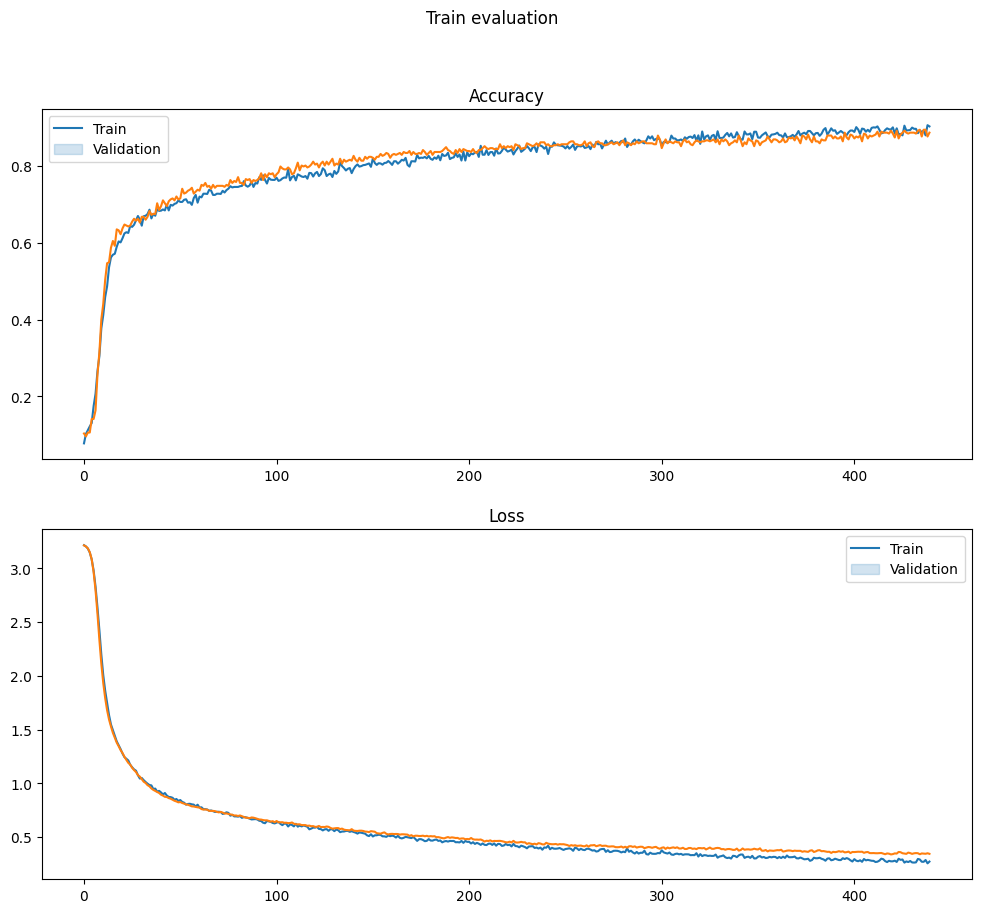

In [17]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [18]:
model_save_path = 'keypoint_classifier/SimpleRNN_model_both_aug.hdf5'
from keras.layers import SimpleRNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(1,2*21)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [19]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 50)             4650      
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
Total params: 22,275
Trainable params: 22,275
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/13 [=>............................] - ETA: 11s - loss: 3.4317 - accuracy: 0.0234
Epoch 1: saving model to keypoint_classifier\SimpleRNN_model_both_aug.hdf5
13/13 [==============================] - 1s 21ms/step - loss: 3.2616 - accuracy: 0.0416 - val_loss: 3.1407 - val_accuracy: 0.0453
Epoch 2/500
 1/13 [=>............................] - ETA: 0s - loss: 3.1263 - accuracy: 0.0781
Epoch 2: saving model to keypoint_classifier\SimpleRNN_model_both_aug.hdf5
13/13 [==============================] - 0s 6ms/step - loss: 3.0799 - accuracy: 0.0939 - val_loss: 3.0162 - val_accuracy: 0.0957
Epoch 3/500
 1/13 [=>............................] - ETA: 0s - loss: 3.0209 - accuracy: 0.1484
Epoch 3: saving model to keypoint_classifier\SimpleRNN_model_both_aug.hdf5
13/13 [==============================] - 0s 5ms/step - loss: 2.9475 - accuracy: 0.1564 - val_loss: 2.8821 - val_accuracy: 0.2065
Epoch 4/500
 1/13 [=>............................] - ETA: 0s - loss: 2.8173 - accuracy: 0.1719
Epoch 

21/21 [==============================] - 0s 937us/step


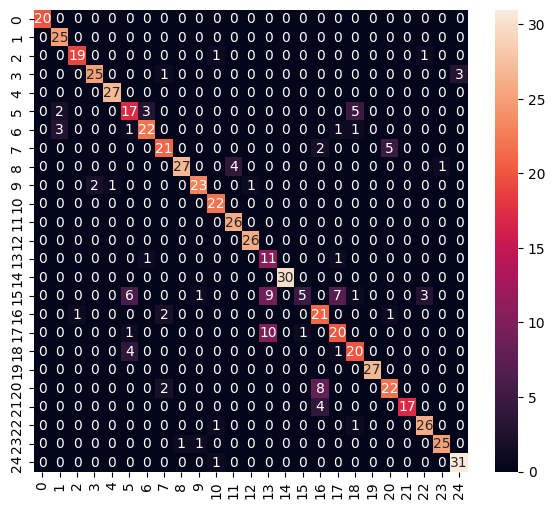

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.83      1.00      0.91        25
           2       0.95      0.90      0.93        21
           3       0.93      0.86      0.89        29
           4       0.96      1.00      0.98        27
           5       0.59      0.63      0.61        27
           6       0.85      0.79      0.81        28
           7       0.81      0.75      0.78        28
           8       0.96      0.84      0.90        32
           9       0.92      0.85      0.88        27
          10       0.88      1.00      0.94        22
          11       0.87      1.00      0.93        26
          12       0.96      1.00      0.98        26
          13       0.37      0.85      0.51        13
          14       1.00      1.00      1.00        30
          15       0.83      0.16      0.26        32
          16       0.60      0.84      0.70        25
     

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [22]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        20
           1      0.833     1.000     0.909        25
           2      0.950     0.905     0.927        21
           3      0.926     0.862     0.893        29
           4      0.964     1.000     0.982        27
           5      0.586     0.630     0.607        27
           6      0.846     0.786     0.815        28
           7      0.808     0.750     0.778        28
           8      0.964     0.844     0.900        32
           9      0.920     0.852     0.885        27
          10      0.880     1.000     0.936        22
          11      0.867     1.000     0.929        26
          12      0.963     1.000     0.981        26
          13      0.367     0.846     0.512        13
          14      1.000     1.000     1.000        30
          15      0.833     0.156     0.263        32
          16      0.600     0.840     0.700        25
          17      0.667    

Text(0.5, 1.0, 'Loss')

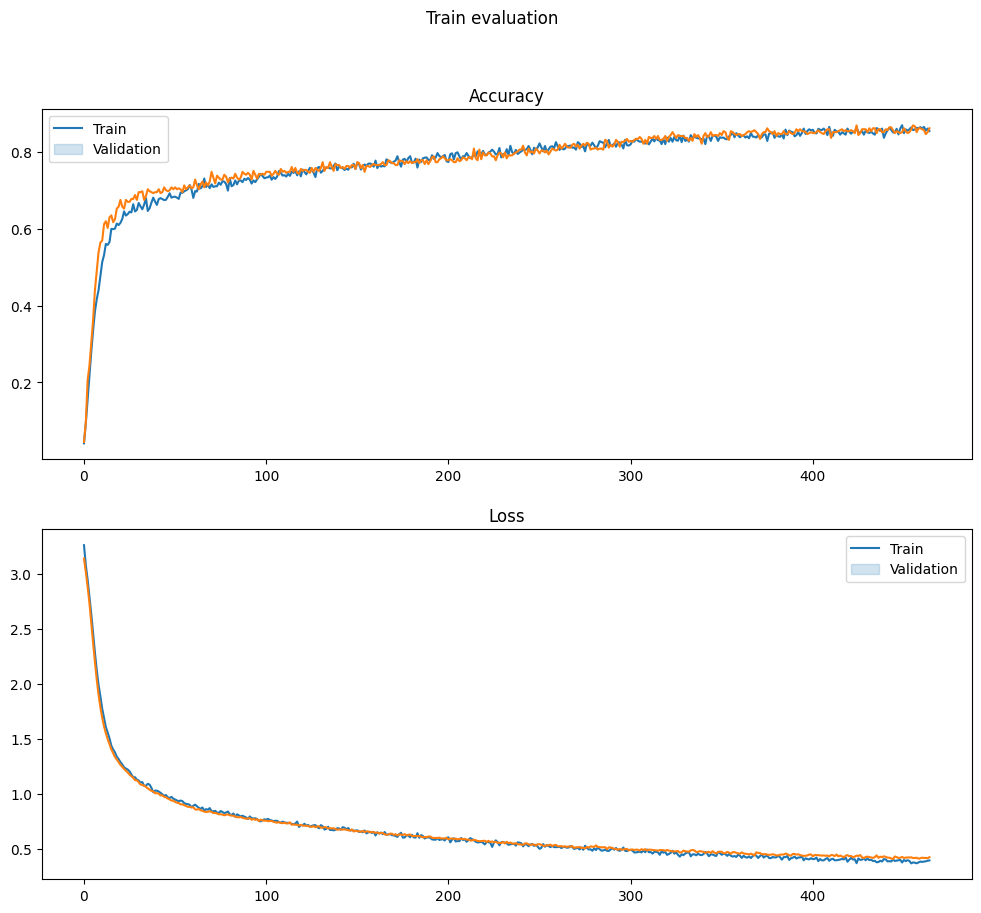

In [23]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [24]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [25]:
model_save_path = 'keypoint_classifier/FF_model_both_aug.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(Dense(256, input_shape=(42,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               11008     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 25)                3225      
                                                                 
Total params: 47,129
Trainable params: 47,129
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
 1/13 [=>............................] - ETA: 3s - loss: 3.2239 - accuracy: 0.0234
Epoch 1: saving model to keypoint_classifier\FF_model_both_aug.hdf5
13/13 [==============================] - 0s 12ms/step - loss: 3.0760 - accuracy: 0.1274 - val_loss: 2.9421 - val_accuracy: 0.1688
Epoch 2/500
 1/13 [=>............................] - ETA: 0s - loss: 2.9193 - accuracy: 0.2031
Epoch 2: saving model to keypoint_classifier\FF_model_both_aug.hdf5
13/13 [==============================] - 0s 5ms/step - loss: 2.7653 - accuracy: 0.2333 - val_loss: 2.6688 - val_accuracy: 0.2166
Epoch 3/500
 1/13 [=>............................] - ETA: 0s - loss: 2.5808 - accuracy: 0.3047
Epoch 3: saving model to keypoint_classifier\FF_model_both_aug.hdf5
13/13 [==============================] - 0s 6ms/step - loss: 2.4465 - accuracy: 0.3354 - val_loss: 2.3652 - val_accuracy: 0.3401
Epoch 4/500
 1/13 [=>............................] - ETA: 0s - loss: 2.2907 - accuracy: 0.3672
Epoch 4: saving model to key

21/21 [==============================] - 0s 880us/step


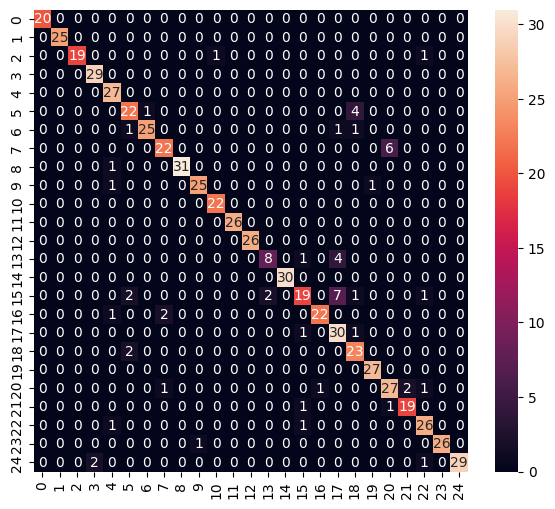

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        25
           2       1.00      0.90      0.95        21
           3       0.94      1.00      0.97        29
           4       0.87      1.00      0.93        27
           5       0.81      0.81      0.81        27
           6       0.96      0.89      0.93        28
           7       0.88      0.79      0.83        28
           8       1.00      0.97      0.98        32
           9       0.96      0.93      0.94        27
          10       0.96      1.00      0.98        22
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        26
          13       0.80      0.62      0.70        13
          14       1.00      1.00      1.00        30
          15       0.83      0.59      0.69        32
          16       0.96      0.88      0.92        25
     

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [28]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        20
           1      1.000     1.000     1.000        25
           2      1.000     0.905     0.950        21
           3      0.935     1.000     0.967        29
           4      0.871     1.000     0.931        27
           5      0.815     0.815     0.815        27
           6      0.962     0.893     0.926        28
           7      0.880     0.786     0.830        28
           8      1.000     0.969     0.984        32
           9      0.962     0.926     0.943        27
          10      0.957     1.000     0.978        22
          11      1.000     1.000     1.000        26
          12      1.000     1.000     1.000        26
          13      0.800     0.615     0.696        13
          14      1.000     1.000     1.000        30
          15      0.826     0.594     0.691        32
          16      0.957     0.880     0.917        25
          17      0.714    

Text(0.5, 1.0, 'Loss')

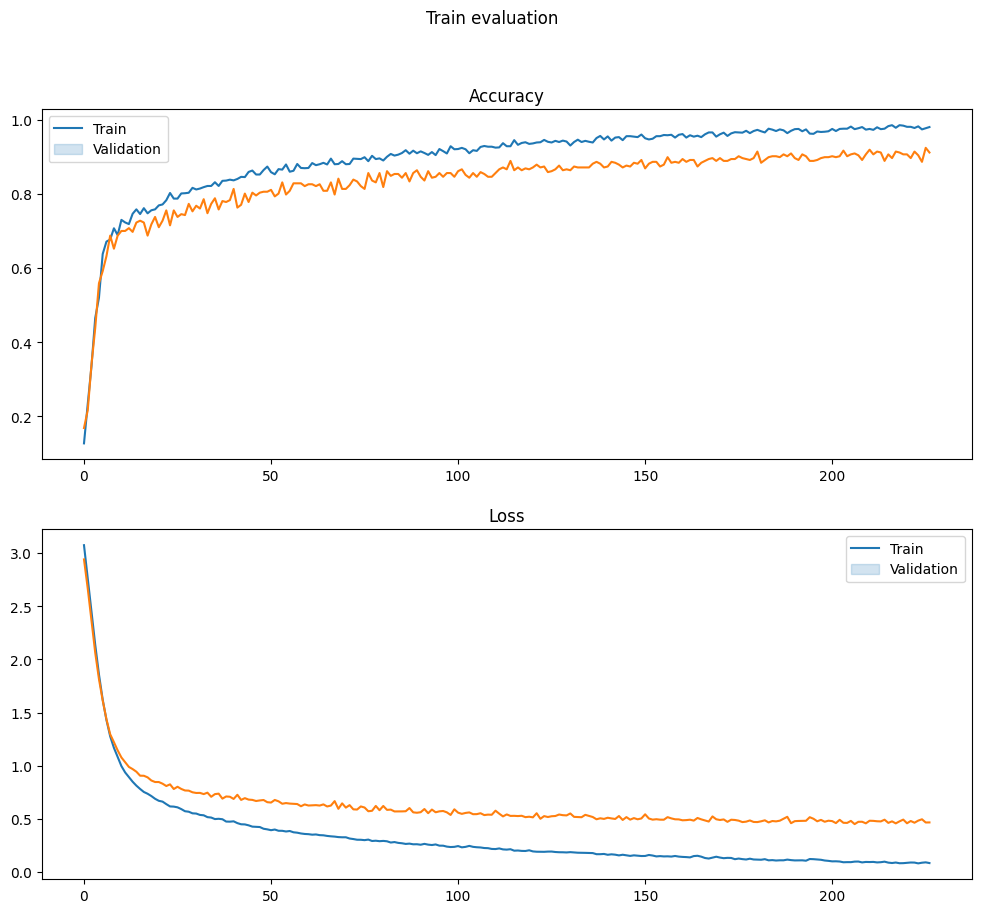

In [29]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them